In [1]:
#from pycaret.time_series import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

Options Pricing functions

In [3]:
def bscall(price,strike,rfr,vol,div,T):
    N=norm.cdf
    d1=(np.log(price/strike)+(rfr-div+vol**2/2)*T)/(vol*np.sqrt(T))
    d2=d1-vol*np.sqrt(T)
    call = price*np.exp(-div*T)*N(d1)-strike*np.exp(-rfr*T)*N(d2)
    return call

def call_price(predictions, strike_price,r, T,M=10_000):
    sd=(predictions['y_pred'].iloc[-1]-predictions['lower'].iloc[-1])/1.96
    dist=np.random.normal(predictions['y_pred'].iloc[-1], sd, size=M)
    payoff=np.maximum(dist-strike_price, 0)
    return np.mean(payoff)*np.exp(-r*T)

def monte_carlo(price,strike,rfr,div,vol,T,M=10_000):
    M=10_000
    np.random.seed(42)
    Z=np.random.normal(size=M)
    ST=price*np.exp((rfr-div-vol**2/2)*T+vol*np.sqrt(T)*Z)
    CT=np.maximum(ST-strike,0.0)
    return np.mean(CT)*np.exp(-rfr*T)

In [4]:
## Macdonald Problem
price=41.0
strike=40.0
rfr=0.08
vol=.30
div=0.0
T=1.0


Simulate Data using geometric brownian motion

In [5]:
mc = monte_carlo(price,strike,rfr,div,vol,T)
bs = bscall(price,strike,rfr,vol,div,T)

print(f"Monte Carlo: {mc}")
print(f"Black Scholes: {bs}")

Monte Carlo: 6.962181464646391
Black Scholes: 6.960998922548743


Use appl stock price

In [36]:
aapl=pd.read_csv('AAPL.csv', index_col=0)
aapl=aapl[['Adj Close']]
aapl.columns=['price']
aapl.drop(aapl.head(2).index, inplace=True)
aapl.index=pd.to_datetime(aapl.index).to_period('B')



idx = pd.period_range(min(aapl.index), max(aapl.index))
aapl = aapl.reindex(idx, fill_value=np.nan)
aapl['price']=pd.to_numeric(aapl['price'])

aapl=aapl.fillna(method='ffill')

<AxesSubplot: >

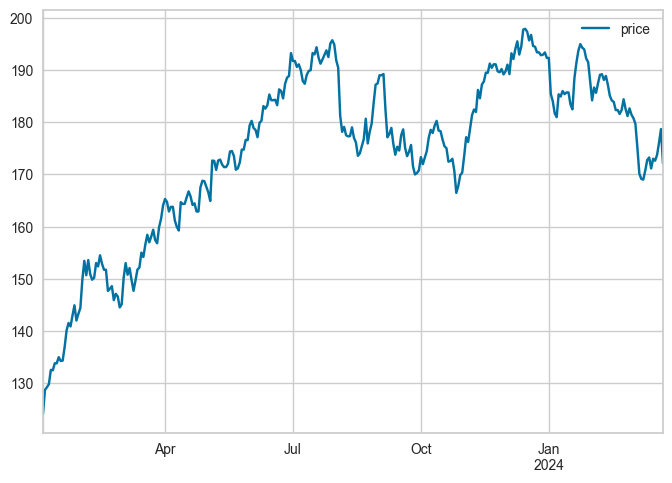

In [37]:
aapl.plot()

In [38]:
from sktime.forecasting.model_selection import SlidingWindowSplitter
ts=np.arange(10)
splitter = SlidingWindowSplitter(fh=np.arange(1,3), window_length=3, step_length=1)
list(splitter.split(ts))


exp = TSForecastingExperiment()
exp = setup(data = aapl, target = 'price',coverage=0.90,fold_strategy=SlidingWindowSplitter(fh=np.arange(1,23), window_length=130, step_length=130))


,Description,Value
0,session_id,6382
1,Target,price
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(316, 1)"
5,Transformed data shape,"(316, 1)"
6,Transformed train set shape,"(294, 1)"
7,Transformed test set shape,"(22, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,SlidingWindowSplitter


In [39]:
exp.compare_models(sort='rmse')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:05:33
Status,. . . . . . . . . . . . . . . . . .,Fitting 2 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Naive Forecaster


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
polytrend,Polynomial Trend Forecaster,0.5277,0.6219,3.0615,4.2567,0.0162,0.0161,-0.4650,0.0200
naive,Naive Forecaster,0.5677,0.6096,3.3424,4.3488,0.0175,0.0177,-0.3752,0.0350
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.5480,0.6406,3.1743,4.3813,0.0168,0.0167,-0.5577,0.2950
theta,Theta Forecaster,0.5322,0.6399,3.1213,4.4823,0.0165,0.0165,-0.4992,0.0400
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.6161,0.7302,3.5643,5.0376,0.0188,0.0188,-0.9854,0.3450
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.6174,0.7321,3.5869,5.0684,0.0189,0.0189,-0.9844,0.3200
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.6177,0.7324,3.5889,5.0706,0.0189,0.0189,-0.9857,0.3250
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.6535,0.7427,3.7996,5.1365,0.0200,0.0201,-1.0450,0.3200
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.6538,0.7429,3.8011,5.1383,0.0200,0.0201,-1.0463,0.3300
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.6603,0.7488,3.8397,5.1827,0.0202,0.0203,-1.0772,0.3200


PolynomialTrendForecaster()

In [41]:
auto_arima=exp.create_model('auto_arima')
huber=exp.tune_model(exp.create_model('polytrend'))

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2023-07-05,0.9971,1.1024,5.2034,6.6375,0.0274,0.0268,-3.5478
1,2024-01-03,0.6604,0.6875,4.2060,5.4964,0.0221,0.0224,-0.6926
Mean,NaT,0.8288,0.8950,4.7047,6.0670,0.0247,0.0246,-2.1202
SD,NaT,0.1683,0.2074,0.4987,0.5705,0.0027,0.0022,1.4276


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2023-07-05,0.5200,0.7246,2.7138,4.3626,0.0144,0.0141,-0.9646
1,2024-01-03,0.5353,0.5192,3.4091,4.1509,0.0180,0.0181,0.0347
Mean,NaT,0.5277,0.6219,3.0615,4.2567,0.0162,0.0161,-0.4650
SD,NaT,0.0076,0.1027,0.3476,0.1058,0.0018,0.0020,0.4996


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2023-07-05,0.5430,0.7446,2.8337,4.4831,0.0150,0.0148,-1.0747
1,2024-01-03,3.3756,2.7560,21.4973,22.0331,0.1149,0.1084,-26.1982
Mean,NaT,1.9593,1.7503,12.1655,13.2581,0.0650,0.0616,-13.6364
SD,NaT,1.4163,1.0057,9.3318,8.7750,0.0499,0.0468,12.5617


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished


In [ ]:
#fh:11, expire: 04/09
auto_arima=exp.finalize_model(auto_arima)
huber=exp.finalize_model(huber)



In [50]:
pred_arima=exp.predict_model(auto_arima, fh=11, return_pred_int=True)
pred_huber=exp.predict_model(huber, fh=11, return_pred_int=True)


pred_arima

,y_pred,lower,upper
2024-03-22,171.6092,168.1405,175.0780
2024-03-25,171.5667,166.3731,176.7603
2024-03-26,170.5019,163.9823,177.0216
2024-03-27,171.0549,163.2654,178.8445
2024-03-28,171.0837,162.2797,179.8878
2024-03-29,171.1705,161.4581,180.8829
2024-04-01,171.4825,160.9168,182.0482
2024-04-02,171.7071,160.3490,183.0652
2024-04-03,170.7883,158.6716,182.9049
2024-04-04,170.6349,157.6415,183.6284


In [93]:
S=172.09
K=165.0
r=0.04284/365
q=0
v=aapl['price'].std()
v=v/np.sqrt(252)
T=15


bscall(S,K,r,v,q,T)
v

1.0238562895946477

In [75]:
print(f'Arima Call Price: {call_price(pred_arima, 165, r, T)}')
print(f'Huber Call Price: {call_price(pred_huber, 165, r, T)}')
print(f'Black-Scholes Call Price: {bscall(S,K,r,v,q,T)}')
print(f'Monte Carlo Call Price: {monte_carlo(S,K,r,q,v,T)}')

print(f'\nMarket Price: {P}')



Arima Call Price: 6.364524643384241
Huber Call Price: nan
Black-Scholes Call Price: 109.5621727801194
Monte Carlo Call Price: 112.4254897072754

Market Price: 8.49


In [56]:
S=41.0
K=40.0
r=0.08
v=.30
q=0.0
X=1.0
bscall(S,K,r,v,q,X)


6.960998922548743